In [2]:
import os
os.chdir('../../')  # for ec2 deployments
print(os.getcwd())

/home/ubuntu/spring-2026-group4


In [3]:
import os

from mypy.checkexpr import defaultdict

In [6]:
import os
import json
import re
from pathlib import Path
from datetime import datetime

DATA_DIR = Path("data/sp500_news")

def count_words(text):
    if not isinstance(text, str):
        return 0
    return len(re.findall(r"\b\w+\b", text))

records = []

for jsonl_file in DATA_DIR.glob("*.jsonl"):
    ticker = jsonl_file.stem

    with open(jsonl_file, encoding="utf-8") as f:
        for line in f:
            try:
                obj = json.loads(line)

                article_text = obj.get("Article", "")
                date_str = obj.get("Date")

                if not date_str:
                    continue

                records.append({
                    "ticker": ticker,
                    "date": datetime.strptime(date_str, "%Y-%m-%d"),
                    "word_count": count_words(article_text)
                })

            except json.JSONDecodeError:
                continue


In [7]:
import pandas as pd

df = pd.DataFrame(records)
df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)

df.head()


KeyError: 'date'

In [15]:
import numpy as np

print("Median words:", np.median(df["word_count"]))
print("Mean words:", np.mean(df["word_count"]))
print("Max words:", np.max(df["word_count"]))
print("25th percentile:", np.percentile(df["word_count"], 25))
print("75th percentile:", np.percentile(df["word_count"], 75))

Median words: 633.0
Mean words: 729.5796307985919
Max words: 7388
25th percentile: 381.0
75th percentile: 904.0


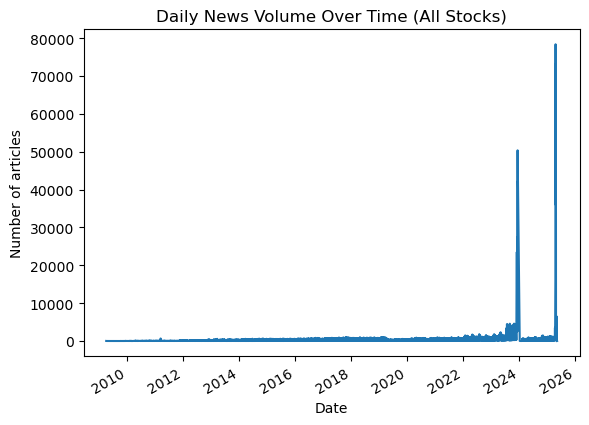

In [16]:
daily_counts = df.groupby("date").size()

import matplotlib.pyplot as plt

plt.figure()
daily_counts.plot()
plt.xlabel("Date")
plt.ylabel("Number of articles")
plt.title("Daily News Volume Over Time (All Stocks)")
plt.show()


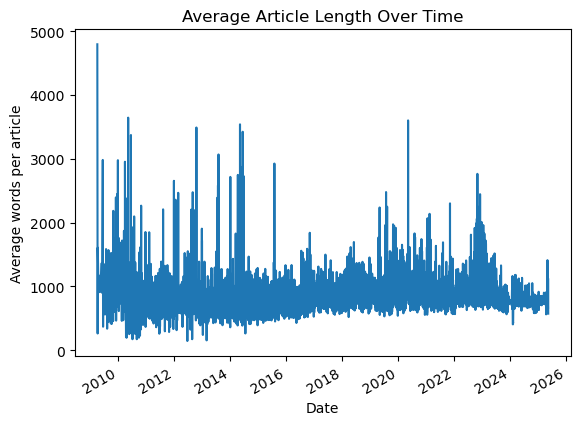

In [17]:
daily_avg_words = df.groupby("date")["word_count"].mean()

plt.figure()
daily_avg_words.plot()
plt.xlabel("Date")
plt.ylabel("Average words per article")
plt.title("Average Article Length Over Time")
plt.show()


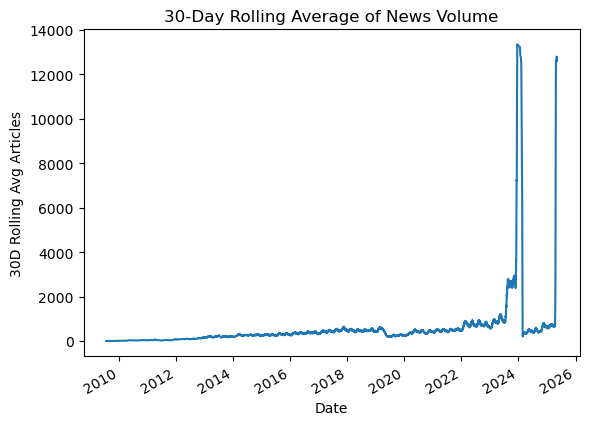

In [18]:
rolling_30d = daily_counts.rolling(30).mean()

plt.figure()
rolling_30d.plot()
plt.xlabel("Date")
plt.ylabel("30D Rolling Avg Articles")
plt.title("30-Day Rolling Average of News Volume")
plt.show()


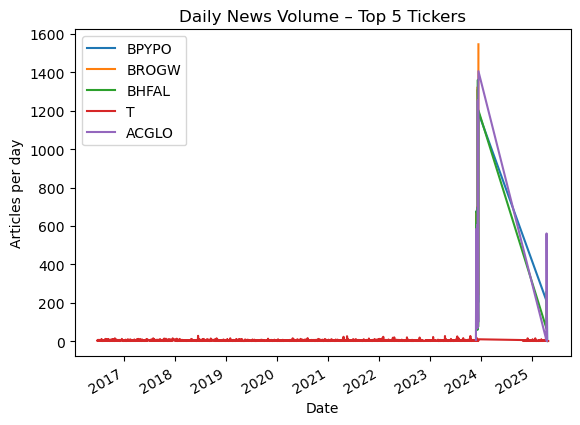

In [ ]:
# top active stocks
top_tickers = (
    df.groupby("ticker")
      .size()
      .sort_values(ascending=False)
      .head(5)
      .index
)

plt.figure()
for t in top_tickers:
    df[df["ticker"] == t].groupby("date").size().plot(label=t)

plt.legend()
plt.xlabel("Date")
plt.ylabel("Articles per day")
plt.title("Daily News Volume – Top 5 Tickers")
plt.show()


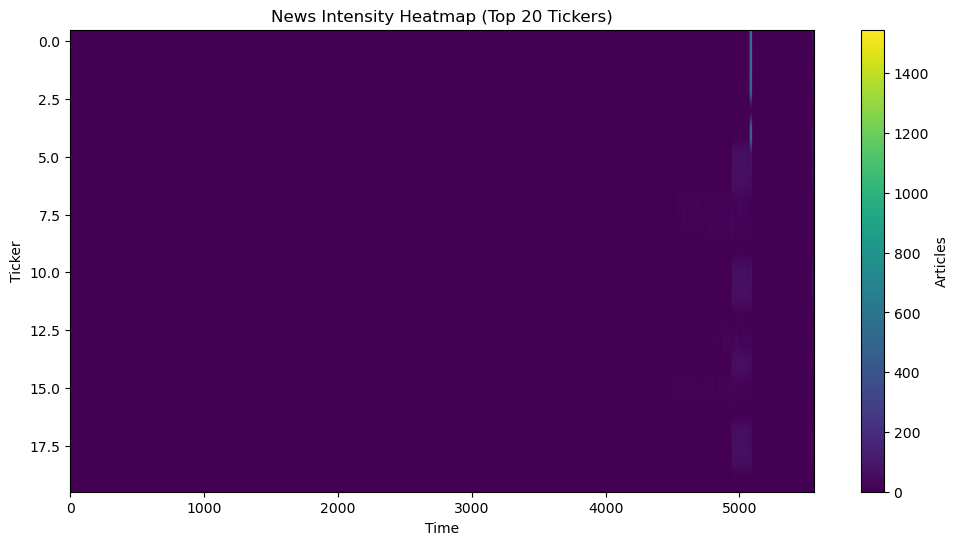

In [20]:
pivot = (
    df.assign(count=1)
      .pivot_table(index="ticker", columns="date", values="count", aggfunc="sum")
      .fillna(0)
)

# reduce size for plotting
top20 = pivot.sum(axis=1).sort_values(ascending=False).head(20).index
pivot_top = pivot.loc[top20]

plt.figure(figsize=(12,6))
plt.imshow(pivot_top, aspect="auto")
plt.colorbar(label="Articles")
plt.xlabel("Time")
plt.ylabel("Ticker")
plt.title("News Intensity Heatmap (Top 20 Tickers)")
plt.show()


In [21]:
ticker_counts = (
    df.groupby("ticker")
      .size()
      .sort_values(ascending=False)
)


In [23]:
top_10 = ticker_counts.head(10)

top_10


ticker
BPYPO    10472
BROGW    10449
BHFAL    10041
T         9947
ACGLO     9545
GSEE      9464
FDEV      9390
AAPL      9311
MSFT      9244
GS        9223
dtype: int64

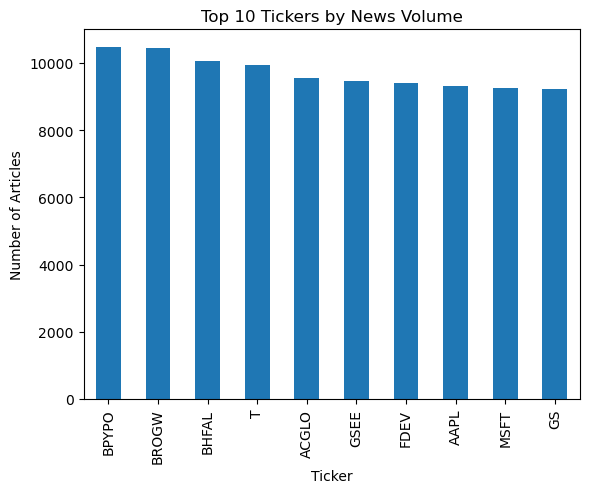

In [24]:
import matplotlib.pyplot as plt

plt.figure()
top_10.plot(kind="bar")
plt.xlabel("Ticker")
plt.ylabel("Number of Articles")
plt.title("Top 10 Tickers by News Volume")
plt.show()


In [26]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.to_period("M")


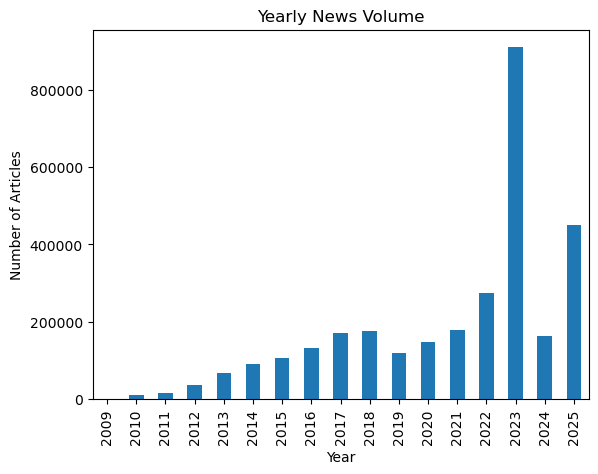

In [29]:
yearly_news = df.groupby("year").size()

plt.figure()
yearly_news.plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.title("Yearly News Volume")
plt.show()


In [ ]:
# sector analysis



In [49]:
df

,ticker,date,word_count,year,month
2330011,EUM,2009-04-08,4771,2009,2009-04
2756805,UYG,2009-04-08,5019,2009,2009-04
680822,UYM,2009-04-08,5019,2009,2009-04
1191738,RXL,2009-04-08,4771,2009,2009-04
2795914,PSQ,2009-04-08,4771,2009,2009-04
...,...,...,...,...,...
73262,HUBB,2025-05-09,173,2025,2025-05
2458875,NXTC,2025-05-09,792,2025,2025-05
2287400,HQY,2025-05-09,254,2025,2025-05
1411344,NUMV,2025-05-09,792,2025,2025-05


In [57]:
import pandas as pd

info = pd.read_csv("/Users/sayam_palrecha/Desktop/spring-2026-group4/src/notebooks/data/sp500stock_data_description.csv")


In [58]:
df["ticker"] = df["ticker"].str.lower()
info["stock_name"] = info["stock_name"].str.lower()


In [59]:
df_with_sector = df.merge(
    info[["stock_name", "Sector"]],
    left_on="ticker",
    right_on="stock_name",
    how="left"
)


In [63]:
df = df_with_sector.copy()
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.to_period("M")


In [64]:
monthly_mean = (
    df.groupby("month")["word_count"]
      .mean()
      .reset_index(name="mean_words")
)


In [65]:
monthly_median = (
    df.groupby("month")["word_count"]
      .median()
      .reset_index(name="median_words")
)


In [66]:
monthly_std = (
    df.groupby("month")["word_count"]
      .std()
      .reset_index(name="std_words")
)


In [67]:
quantiles = (
    df.groupby("month")["word_count"]
      .quantile([0.1, 0.25, 0.5, 0.75, 0.9])
      .unstack()
      .reset_index()
)


In [69]:
top_10_tickers = (
    df_with_sector
    .groupby("ticker")["word_count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)


In [72]:
df_top10 = df_with_sector[df_with_sector["ticker"].isin(top_10_tickers)].copy()
df_top10["year"] = df_top10["date"].dt.to_period("Y")

quantiles_top10 = (
    df_top10
    .groupby("year")["word_count"]
    .quantile([0.1, 0.25, 0.5, 0.75, 0.9])
    .unstack()
    .reset_index()
)


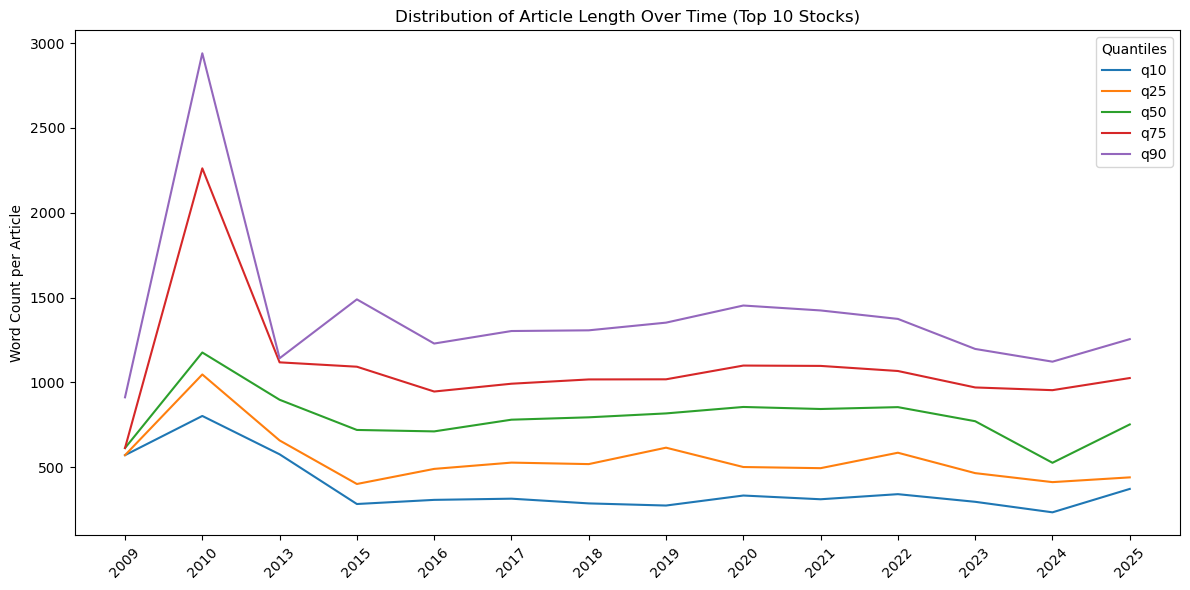

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for q in [0.1, 0.25, 0.5, 0.75, 0.9]:
    plt.plot(
        quantiles_top10["year"].astype(str),
        quantiles_top10[q],
        label=f"q{int(q*100)}"
    )

plt.legend(title="Quantiles")
plt.xticks(rotation=45)
plt.ylabel("Word Count per Article")
plt.title("Distribution of Article Length Over Time (Top 10 Stocks)")
plt.tight_layout()
plt.show()


In [75]:
df = df_with_sector.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

year_sector = (
    df.groupby(["year", "Sector"])["word_count"]
      .median()
      .reset_index(name="median_words")
)


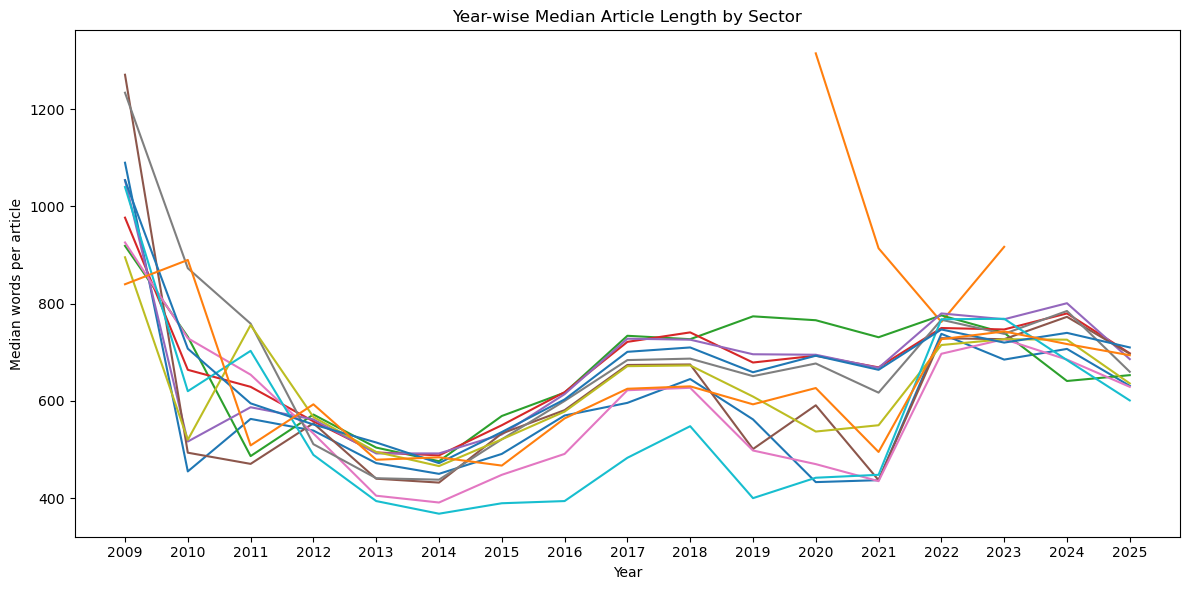

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_with_sector.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

year_sector = (
    df.groupby(["year", "Sector"])["word_count"]
      .median()
      .reset_index()
)

# pivot to wide for matplotlib
wide = year_sector.pivot(index="year", columns="Sector", values="word_count").sort_index()

plt.figure(figsize=(12,6))
plt.plot(wide.index, wide.values)  # many lines, one per sector
plt.title("Year-wise Median Article Length by Sector")
plt.xlabel("Year")
plt.ylabel("Median words per article")
plt.xticks(wide.index)
plt.tight_layout()
plt.show()


In [81]:
import pandas as pd

df = df_with_sector.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

heatmap_data = (
    df.groupby(["Sector", "year"])["word_count"]
      .median()
      .reset_index()
)

pivot = heatmap_data.pivot(
    index="Sector",
    columns="year",
    values="word_count"
)


In [82]:
pivot = pivot.loc[pivot.median(axis=1).sort_values(ascending=False).index]


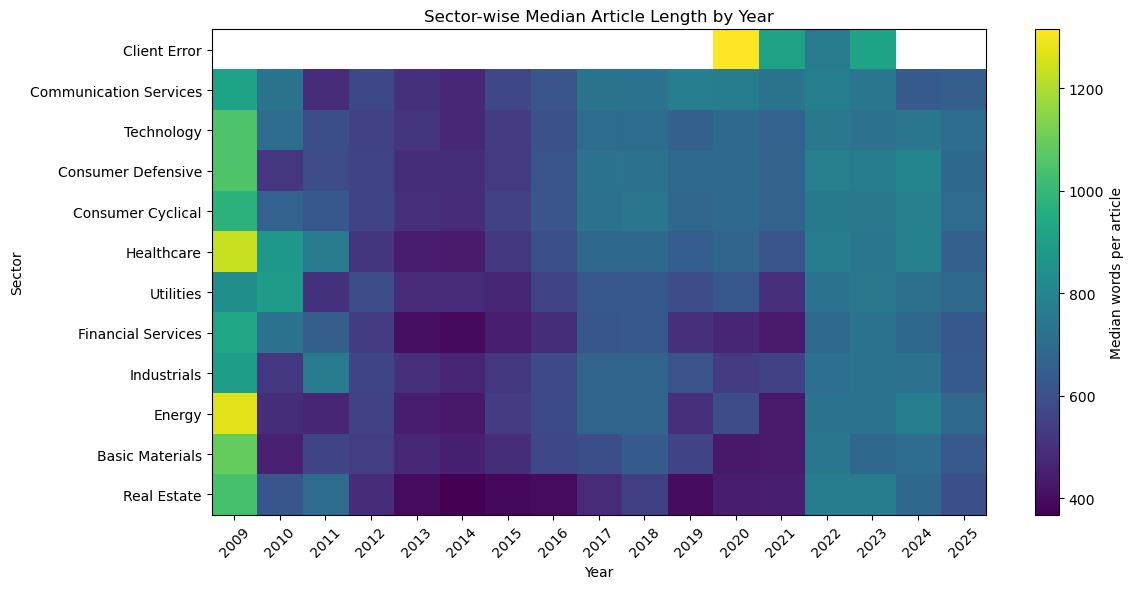

In [83]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,6))

im = plt.imshow(pivot.values, aspect="auto")

plt.colorbar(im, label="Median words per article")

plt.yticks(
    ticks=np.arange(len(pivot.index)),
    labels=pivot.index
)

plt.xticks(
    ticks=np.arange(len(pivot.columns)),
    labels=pivot.columns,
    rotation=45
)

plt.title("Sector-wise Median Article Length by Year")
plt.xlabel("Year")
plt.ylabel("Sector")

plt.tight_layout()
plt.show()
